In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
#import pyplot as plt
#import seaborn as sns

In [89]:
import bbknn

In [98]:
results_file = './out/covid_pbmc.h5ad'

In [14]:
adata1 = sc.read_text('/Volumes/LACIE_SHARE/Calla/Inputs/inputs/well1/GEX_counts.tsv', delimiter= '\t', first_column_names=True).transpose()
adata2 = sc.read_text('/Volumes/LACIE_SHARE/Calla/Inputs/inputs/well2/GEX_counts.tsv', delimiter= '\t', first_column_names=True).transpose()
adata3 = sc.read_text('/Volumes/LACIE_SHARE/Calla/Inputs/inputs/well3/GEX_counts.tsv', delimiter= '\t', first_column_names=True).transpose()
adata4 = sc.read_text('/Volumes/LACIE_SHARE/Calla/Inputs/inputs/well4/GEX_counts.tsv', delimiter= '\t', first_column_names=True).transpose()

In [47]:
md1 = pd.read_csv('/Volumes/LACIE_SHARE/Calla/Inputs/inputs/well1/metadata.tsv', delimiter= '\t').set_index('BARCODE')
adata1.obs = adata1.obs.join(md1)
md2 = pd.read_csv('/Volumes/LACIE_SHARE/Calla/Inputs/inputs/well2/metadata.tsv', delimiter= '\t').set_index('BARCODE')
adata2.obs = adata2.obs.join(md2)
md3 = pd.read_csv('/Volumes/LACIE_SHARE/Calla/Inputs/inputs/well3/metadata.tsv', delimiter= '\t').set_index('BARCODE')
adata3.obs = adata3.obs.join(md3)
md4 = pd.read_csv('/Volumes/LACIE_SHARE/Calla/Inputs/inputs/well4/metadata.tsv', delimiter= '\t').set_index('BARCODE')
adata4.obs = adata4.obs.join(md4)

In [48]:
adata = adata1.concatenate(adata2,adata3,adata4) #concatenate wells together, batch number is now in obs

In [59]:
adata.var_names = adata.var_names.str.split(pat='|').str[1]
adata.var_names_make_unique()

In [60]:
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)

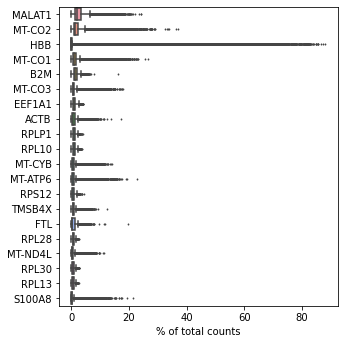

In [61]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [62]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/Applications/EMAN2/envs/immunox_hack/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [63]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None,  inplace=True)

/Applications/EMAN2/envs/immunox_hack/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'DROPLET.TYPE' as categorical
... storing 'BEST.GUESS' as categorical
... storing 'SAMPLE.by.SNPs' as categorical
/Applications/EMAN2/envs/immunox_hack/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Applications/EMAN2/envs/immunox_hack/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Applications/EMAN2/envs/immunox_hack/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnin

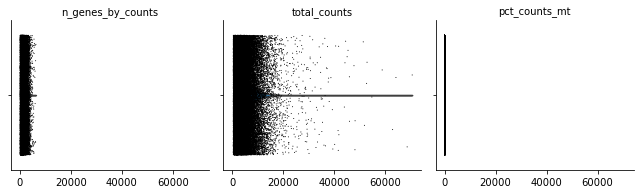

In [64]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

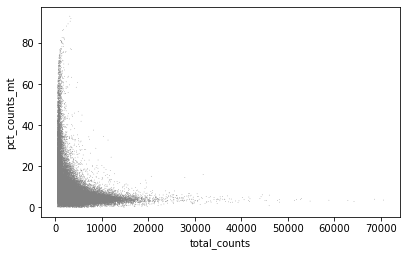

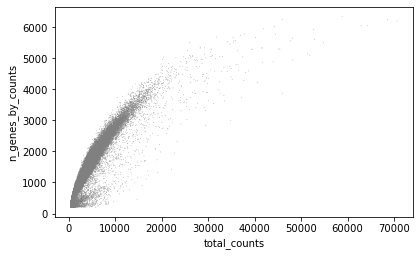

In [65]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [66]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

/Applications/EMAN2/envs/immunox_hack/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Applications/EMAN2/envs/immunox_hack/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [75]:
adata = adata[adata.obs['DROPLET.TYPE'] == 'SNG'] # filter out presumed heterotypic doublets

In [67]:
sc.pp.normalize_total(adata, target_sum=1e4)

/Applications/EMAN2/envs/immunox_hack/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


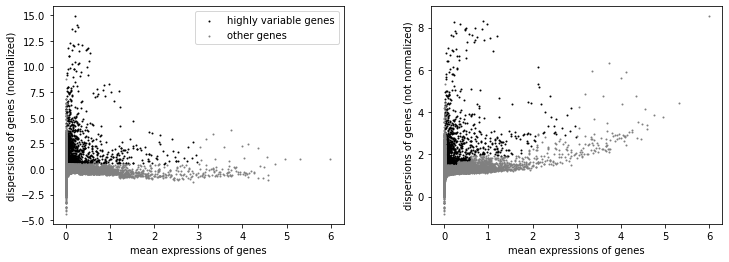

In [68]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [69]:
adata = adata[:, adata.var.highly_variable]

In [77]:
sc.pp.scale(adata, max_value=10)

/Applications/EMAN2/envs/immunox_hack/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [78]:
sc.tl.pca(adata, svd_solver='arpack')

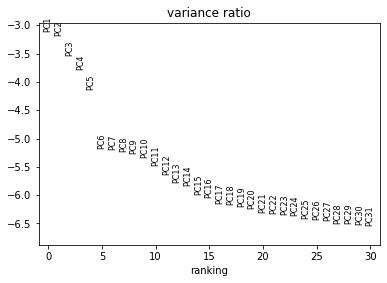

In [91]:
sc.pl.pca_variance_ratio(adata, log=True)

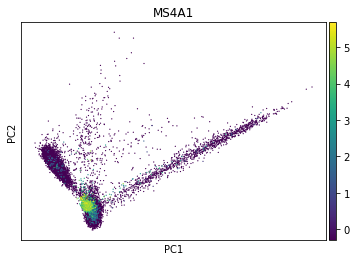

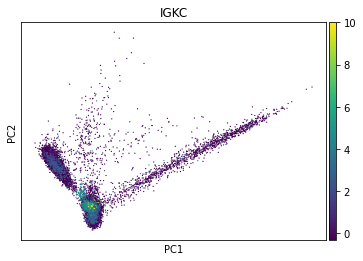

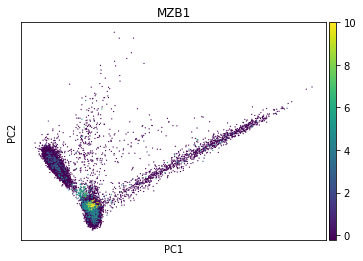

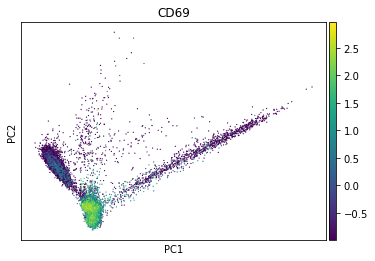

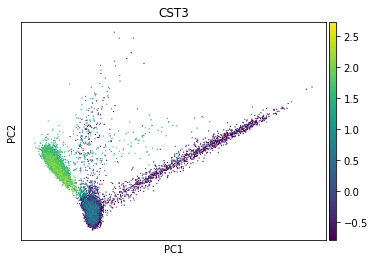

In [84]:
sc.pl.pca(adata, color='MS4A1')
sc.pl.pca(adata, color='IGKC')
sc.pl.pca(adata, color='MZB1')
sc.pl.pca(adata, color='CD69')
sc.pl.pca(adata, color='CST3')

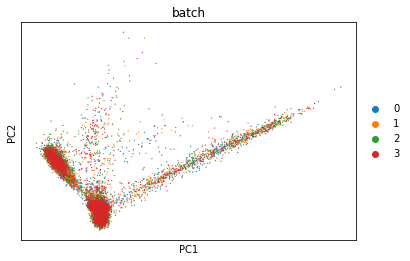

In [86]:
sc.pl.pca(adata, color='batch')

In [99]:
adata.write(results_file)

In [92]:
sc.external.pp.bbknn(adata, n_pcs=30)

In [93]:
sc.tl.umap(adata)

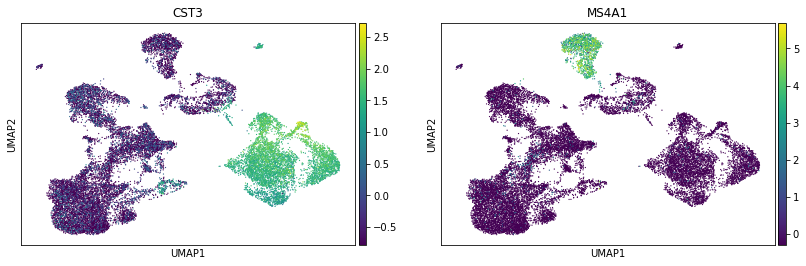

In [101]:
sc.pl.umap(adata, color=['CST3', 'MS4A1'], save = '1.pdf')

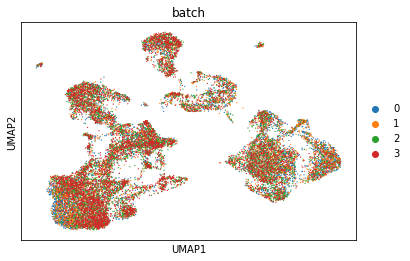

In [97]:
sc.pl.umap(adata, color=['batch'])

In [102]:
sc.tl.leiden(adata)

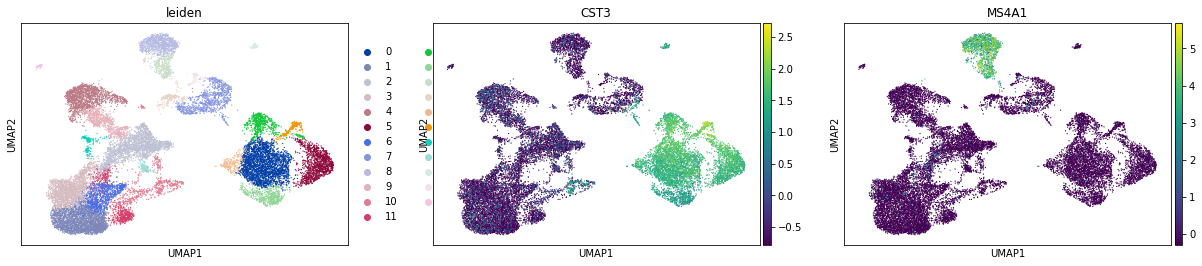

In [103]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'MS4A1'])